In [0]:
%%time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 640 µs, sys: 0 ns, total: 640 µs
Wall time: 513 µs


### Importing the essential libraries

In [0]:
from pathlib import Path
import os
import glob
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import torchvision
from torch import nn
import torch 
import cv2

In [0]:
# Changing the directory path
%cd /content/drive/My\ Drive/EVA4/assignment15

/content/drive/My Drive/EVA4/assignment15


### Loading Zip Files in the memory of Colab

In [0]:
%%time
!mkdir /content/Data
!mkdir /content/Data/Background/
!mkdir /content/Data/OverlayedImages/
!mkdir /content/Data/OverlayedMasks/
!mkdir /content/Data/DepthImage/
!unzip -q ZippedFiles/Background.zip -d /content/Data/Background/
!unzip -q ZippedFiles/OverlayedImages.zip -d /content/Data/OverlayedImages/
!unzip -q ZippedFiles/OverlayedImages1.zip -d /content/Data/OverlayedImages/
!unzip -q ZippedFiles/OverlayedImages2.zip -d /content/Data/OverlayedImages/
!unzip -q ZippedFiles/OverlayedImages3.zip -d /content/Data/OverlayedImages/
!unzip -q ZippedFiles/DepthImage.zip -d /content/Data/DepthImage/
!unzip -q ZippedFiles/DepthImage1.zip -d /content/Data/DepthImage/
!unzip -q ZippedFiles/DepthImage2.zip -d /content/Data/DepthImage/
!unzip -q ZippedFiles/DepthImage3.zip -d /content/Data/DepthImage/
!unzip -q ZippedFiles/OverlayedMasks.zip -d /content/Data/OverlayedMasks/
!unzip -q ZippedFiles/OverlayedMasks1.zip -d /content/Data/OverlayedMasks/
!unzip -q ZippedFiles/OverlayedMasks2.zip -d /content/Data/OverlayedMasks/
!unzip -q ZippedFiles/OverlayedMasks3.zip -d /content/Data/OverlayedMasks/
!rm -rf Data/Background/Thumbs.db
!rm -rf /content/Data/OverlayedImages/*/Thumbs.db
!rm -rf /content/Data/OverlayedMasks/*/Thumbs.db
!rm -rf /content/Data/DepthImage/*/Thumbs.db

CPU times: user 1.18 s, sys: 264 ms, total: 1.45 s
Wall time: 9min 20s


### Removing Corrupted Files

In [0]:
!rm -rf /content/Data/OverlayedImages/30/combined_s47_p16_it30.jpg
!rm -rf /content/Data/OverlayedMasks/30/combined_s47_p16_it30.jpg
!rm -rf /content/Data/DepthImage/30/combined_s47_p16_it30.jpg
!rm -rf /content/Data/OverlayedMasks/20/combined_s9_p61_it20.jpg
!rm -rf /content/Data/OverlayedImages/20/combined_s9_p61_it20.jpg
!rm -rf /content/Data/DepthImage/20/combined_s9_p61_it20.jpg

In [0]:
data_root = '/content/Data/'
data_root

'/content/Data/'

In [0]:
from dataset import DSet
from augmentation import Augmentation
from model import Net

dataset = DSet(data_root)
print(len(dataset))

399998


### Dividing into Train and Test (70:30)

In [0]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset)), print(len(test_dataset))

279998
120000


(None, None)

### Creating the Data Loaders

In [0]:
train = torch.utils.data.Subset(train_dataset, range(0, len(train_dataset)//1))
train_dataloader = DataLoader(train, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [0]:
batch_size=32
print(f'Train dataset has {len(train_dataloader)} batches of size {batch_size}')
print(f'Train dataset has {len(test_dataloader)} batches of size {batch_size}')

Train dataset has 8750 batches of size 32
Train dataset has 3750 batches of size 32


In [0]:
sample = next(iter(train_dataloader))

In [0]:
[(k, v.shape) for k, v in sample.items()]

[('f1', torch.Size([32, 3, 64, 64])),
 ('f2', torch.Size([32, 3, 64, 64])),
 ('f3', torch.Size([32, 1, 64, 64])),
 ('f4', torch.Size([32, 1, 64, 64]))]

In [0]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
netobj = Net()
model = netobj.to(device)
# print(model)

In [0]:
#create Saved Models folder
# PATH = './saved_models1/'
#Loading the saved model
# model.load_state_dict = (torch.load(PATH + '1_8000_0.15327014029026031.pth'))

In [0]:
# !pip install kornia

     |████████████████████████████████| 163kB 8.9MB/s 


In [0]:
# import kornia
# criterion_depth = kornia.losses.SSIM(1, reduction='mean')

In [0]:
# import pytorch_ssim
# optim = torch.optim.Adam(model.parameters(), lr=1e-2)
# from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# criterion = pytorch_ssim.SSIM()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.L1Loss()

# criterion_depth = nn.L1Loss()
# criterion_mask = nn.BCEWithLogitsLoss()
# criterion = nn.SmoothL1Loss()
optim = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optim, step_size = 1, gamma=0.01)
# scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [0]:
from torchsummary import summary
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             864
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]             576
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]          73,728
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           1,152
      BatchNorm2d-14          [-1, 128,

In [0]:
from tqdm import tqdm 
PATH = Path('./saved_models1/')
PATH.mkdir(exist_ok = True)
Path("plots1").mkdir(exist_ok=True)

In [0]:
from training import calculate_iou, show, save_plot, train, test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch ID:  0
Train Epoch: 1 [0/279998 (0%)]	Loss: 1.483267
Loss Mask:  0.2892971634864807
Loss Depth:  0.5969850420951843
IOU Depth:  0.01654398367465928
IOU Mask:  0.05786608600979858
Batch ID: 0
time took for 100 batches: 0.004478931427001953
Ground Truth of Depth:


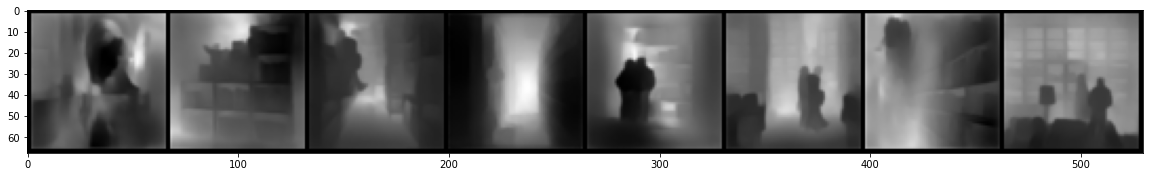

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


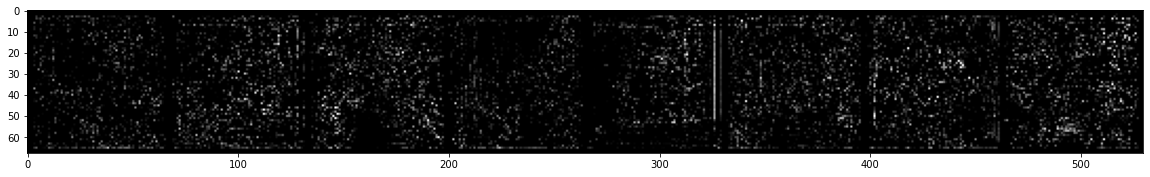

Ground Truth of Mask:


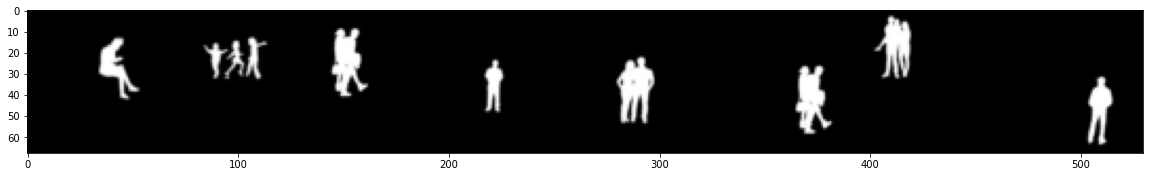

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


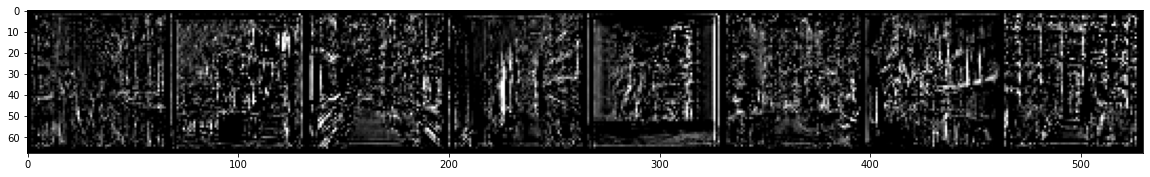

Batch ID:  10
Batch ID:  20
Batch ID:  30
Batch ID:  40
Batch ID:  50
Batch ID:  60
Batch ID:  70
Batch ID:  80


In [0]:
#With L1Loss() 
for epoch in range(1,11):
  train(model, criterion, device, train_dataloader, optim, epoch)
  # test(model, criterion, device, test_dataloader)
  scheduler.step()

In [0]:
#With L1Loss() 
for epoch in range(1,11):
  test(model, criterion, device, train_dataloader, optim, epoch)
  scheduler.step()